In [61]:
import numpy as np
import random
import matplotlib.pyplot as plt
import xarray as xr

In [62]:
#Hourly 2D bottom currents
jan_jun = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc")
jun_aug = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jun-aug.nc")
sep_dec = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_sep-dec.nc")

In [63]:
print(len(jan_jun.variables['time']))

4201


In [64]:
#Remove overlap
jan_jun = jan_jun.isel(time=slice(0, -360))  
jun_aug = jun_aug.isel(time=slice(0, -192))  

In [ ]:
#Merge (not possible with this memory size.. Can do this later if necessary)
current_2019 = xr.concat([current_jan_jun, current_jun_aug, current_sep_dec], dim="time")

In [65]:
#Importing coral data
import pandas as pd

coral_data = pd.read_parquet('/cluster/home/maikents/midnor_total_coral_data_processed_v2.parquet')


In [30]:
print(len(coral_data))

941


In [19]:
#Histogram for bottom current speed
hor_res = jun_aug.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0,1)#(0, len(jun_aug.variables['time']))
coral_values_jun_aug = []
valid_coords_jun_aug = []
xc_max = jun_aug.variables['xc'].shape[0]
yc_max = jun_aug.variables['yc'].shape[0]
for time in range(t_start, t_stop):
        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            x = np.clip(np.round(coral_data['x']/hor_res).astype(int), 0, xc_max-1)
            y = np.clip(np.round(coral_data['y']/hor_res).astype(int), 0, yc_max-1)
            value = np.sqrt(jun_aug.variables['u-bottom'][time, y, x]**2 + jun_aug.variables['v-bottom'][time, y, x]**2)
            if not np.ma.is_masked(value):
                coral_values_jun_aug.append(value)
    
                    


In [44]:
print(len(jun_aug.variables['time']))

2014


In [45]:
import time
import numpy as np

hor_res = jun_aug.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, 2014)  # (0, len(jun_aug.variables['time']))
coral_values_jun_aug = []
valid_coords_jun_aug = []
xc_max = jun_aug.variables['xc'].shape[0]
yc_max = jun_aug.variables['yc'].shape[0]

timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(jun_aug.variables['u-bottom'][time_idx, y, x]**2 +
                            jun_aug.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_jun_aug.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 2013
Grid size: xc_max=950, yc_max=555

Total execution time: 1528.262462 seconds
Time step 0, Point 0 (x=705, y=179) - 0.001199 sec
Time step 0, Point 1 (x=612, y=44) - 0.000740 sec
Time step 0, Point 2 (x=528, y=176) - 0.000711 sec
Time step 0, Point 3 (x=637, y=157) - 0.000777 sec
Time step 0, Point 4 (x=586, y=182) - 0.000789 sec
Time step 0, Point 5 (x=744, y=138) - 0.000757 sec
Time step 0, Point 6 (x=582, y=113) - 0.000760 sec
Time step 0, Point 7 (x=631, y=169) - 0.000760 sec
Time step 0, Point 8 (x=584, y=71) - 0.000785 sec
Time step 0, Point 9 (x=571, y=179) - 0.000747 sec


In [49]:
#Convert list to numpy array for easier manipulation
coral_values_jun_aug = np.array(coral_values_jun_aug)


In [50]:
print(len(coral_values_jun_aug))

1895174


In [53]:
current_speed_df = pd.DataFrame({'current speed jun_aug': coral_values_jun_aug})
#current_speed_df.to_csv("coral_values_jun_aug.csv", index=False)

In [55]:
print(len(jan_jun.variables['time']))

3481


In [57]:
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, 2000)  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun = []
valid_coords_jan_jun = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]

timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(jan_jun.variables['u-bottom'][time_idx, y, x]**2 +
                            jan_jun.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_jan_jun.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 1999
Grid size: xc_max=950, yc_max=555

Total execution time: 1453.584112 seconds
Time step 0, Point 0 (x=705, y=179) - 0.951020 sec
Time step 0, Point 1 (x=612, y=44) - 0.000978 sec
Time step 0, Point 2 (x=528, y=176) - 0.000736 sec
Time step 0, Point 3 (x=637, y=157) - 0.000710 sec
Time step 0, Point 4 (x=586, y=182) - 0.000729 sec
Time step 0, Point 5 (x=744, y=138) - 0.000764 sec
Time step 0, Point 6 (x=582, y=113) - 0.000706 sec
Time step 0, Point 7 (x=631, y=169) - 0.000698 sec
Time step 0, Point 8 (x=584, y=71) - 0.000701 sec
Time step 0, Point 9 (x=571, y=179) - 0.000698 sec


In [70]:
print(len(sep_dec.variables['time']))

2928


In [71]:
hor_res = sep_dec.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, 2928)  # (0, len(jun_aug.variables['time']))
coral_values_sep_dec = []
valid_coords_sep_dec = []
xc_max = sep_dec.variables['xc'].shape[0]
yc_max = sep_dec.variables['yc'].shape[0]

timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(sep_dec.variables['u-bottom'][time_idx, y, x]**2 +
                            sep_dec.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_sep_dec.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 2927
Grid size: xc_max=950, yc_max=555

Total execution time: 2229.990836 seconds
Time step 0, Point 0 (x=705, y=179) - 0.641473 sec
Time step 0, Point 1 (x=612, y=44) - 0.000939 sec
Time step 0, Point 2 (x=528, y=176) - 0.000814 sec
Time step 0, Point 3 (x=637, y=157) - 0.000800 sec
Time step 0, Point 4 (x=586, y=182) - 0.000792 sec
Time step 0, Point 5 (x=744, y=138) - 0.000788 sec
Time step 0, Point 6 (x=582, y=113) - 0.000780 sec
Time step 0, Point 7 (x=631, y=169) - 0.000785 sec
Time step 0, Point 8 (x=584, y=71) - 0.000790 sec
Time step 0, Point 9 (x=571, y=179) - 0.000777 sec


In [60]:
coral_values_jan_jun_flat = np.ravel(coral_values_jan_jun)  # Flattening the first array
coral_values_jun_aug_flat = np.ravel(coral_values_jun_aug)  # Flattening the second array
print(len(coral_values_jun_aug_flat))
# Concatenate the flattened arrays
all_current_speeds = np.concatenate((coral_values_jan_jun_flat, coral_values_jun_aug_flat))

# Create DataFrame with one column
current_speed_df = pd.DataFrame({'current speeds': all_current_speeds})

# Save to CSV
current_speed_df.to_csv("coral_values.csv", index=False)

1895174


In [69]:
coral_values_jan_jun2_flat = np.ravel(coral_values_jan_jun2)
all_current_speeds = np.concatenate((coral_values_jan_jun_flat, coral_values_jun_aug_flat, coral_values_jan_jun2_flat))
current_speed_df = pd.DataFrame({'current speeds': all_current_speeds})
current_speed_df.to_csv("coral_values.csv", index=False)

In [72]:
coral_values_sep_dec_flat = np.ravel(coral_values_sep_dec)
all_current_speeds = np.concatenate((coral_values_jan_jun_flat, coral_values_jan_jun2_flat, coral_values_jun_aug_flat, coral_values_sep_dec_flat))
current_speed_df = pd.DataFrame({'current speeds': all_current_speeds})
current_speed_df.to_csv("coral_values.csv", index=False)

In [79]:
current_speeds = current_speed_df['current speeds'].dropna().values
current_speed_df.to_csv("coral_values.csv", index=False)

In [ ]:
hor_res = jan_jun.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (2001, 3481)  # (0, len(jun_aug.variables['time']))
coral_values_jan_jun2 = []
valid_coords_jan_jun2 = []
xc_max = jan_jun.variables['xc'].shape[0]
yc_max = jan_jun.variables['yc'].shape[0]

timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:
            value = np.sqrt(jan_jun.variables['u-bottom'][time_idx, y, x]**2 +
                            jan_jun.variables['v-bottom'][time_idx, y, x]**2)
            
            #print(f"Point {i}: (x={x}, y={y}) -> Current Speed: {value:.6f}")

            if not np.ma.is_masked(value):
                coral_values_jan_jun2.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

In [81]:
# Calculate statistics for coral values
if 'current speeds' not in current_speed_df.columns:
    print("Error: 'current speeds' column not found in CSV!")
else:
    # Drop NaNs and convert to NumPy array
    current_speeds = current_speed_df['current speeds'].dropna().values

    # Check for empty array
    if len(current_speeds) == 0:
        print("Error: current_speeds array is empty after dropping NaNs!")
    else:
        # Compute statistics
        statistics = {
            'mean': np.float32(np.mean(current_speeds)),
            'max': np.float32(np.max(current_speeds)),
            'min': np.float32(np.min(current_speeds)),
            '90th_percentile': np.float32(np.percentile(current_speeds, 90)),
            '10th_percentile': np.float32(np.percentile(current_speeds, 10))
        }

        print("Statistics for current speed:", statistics)

Statistics for current speed: {'mean': np.float32(0.09981488), 'max': np.float32(0.7515798), 'min': np.float32(0.0), '90th_percentile': np.float32(0.19479178), '10th_percentile': np.float32(0.028968481)}


In [82]:
#Determine the bin edges for the histograms
bin_edges = np.histogram_bin_edges(current_speeds, bins=20)

In [ ]:
np.savetxt("bin_edges.csv", bin_edges, delimiter=",")


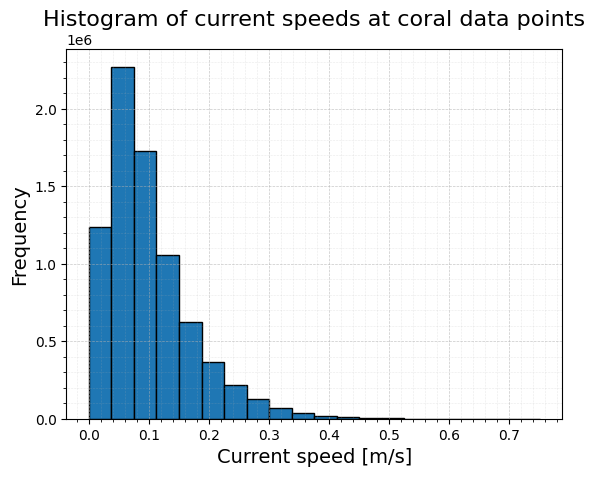

In [86]:
#Plot histogram of the current speeds
plt.hist(current_speeds, bins=bin_edges, edgecolor='black')
plt.xlabel('Current speed [m/s]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of current speeds at coral data points', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Main grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)  # Finer minor grid

plt.savefig(f'/cluster/home/maikents/current_speed_histogram_coral_points_jun_aug.png')
 
plt.show()

In [94]:
midnor_2019 = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc")


In [95]:
print(list(midnor_2019.variables))

['time', 'grid_mapping', 'LayerDepths', 'xc', 'yc', 'zc', 'depth', 'DXxDYy', 'u_velocity', 'v_velocity', 'elevation', 'temperature', 'salinity', 'ice_thickness', 'ice_compactness', 'salinity_ice']


In [99]:
print(midnor_2019.variables['u_velocity'])

<xarray.Variable (time: 365, zc: 50, yc: 555, xc: 950)> Size: 38GB
[9622312500 values with dtype=float32]
Attributes:
    units:         m/s
    cell_methods:  time: mean


In [100]:
hor_res = midnor_2019.grid_mapping.attrs['horizontal_resolution']
t_start, t_stop = (0, len(midnor_2019.variables['time']))
coral_values_midnor_2019 = []
valid_coords_midnor_2019 = []
xc_max = midnor_2019.variables['xc'].shape[0]
yc_max = midnor_2019.variables['yc'].shape[0]
zc = midnor_2019.variables['LayerDepths'][:]
cumulative_depth = np.cumsum(zc, axis=0)
timing_results = []

start_total = time.perf_counter()  # Track total execution time

print(f"Processing from time index {t_start} to {t_stop-1}")
print(f"Grid size: xc_max={xc_max}, yc_max={yc_max}")

for time_idx in range(t_start, t_stop):
    start_time = time.perf_counter()
    #print(f"\nProcessing timestep {time_idx}...")

    # Precompute x and y indices
    x_indices = np.clip(np.round(coral_data['x'] / hor_res).astype(int), 0, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y'] / hor_res).astype(int), 0, yc_max - 1)

    #print(f"Total coral points: {len(x_indices)}")
    
    for i, (x, y) in enumerate(zip(x_indices, y_indices)):
        step_start = time.perf_counter()

        # Check if indices are within bounds
        if 0 <= x < xc_max and 0 <= y < yc_max:

            depth_at_point = midnor_2019.variables['depth'][int(y), int(x)]
            layer_index = np.searchsorted(cumulative_depth, depth_at_point)

            value = np.sqrt(midnor_2019.variables['u_velocity'][time_idx, layer_index, int(y), int(x)]**2 + midnor_2019.variables['v_velocity'][time_idx, layer_index, int(y), int(x)]**2)

            if not np.ma.is_masked(value):
                coral_values_midnor_2019.append(value)
                #print(f"Value at ({x}, {y}) added: {value:.6f}")
            else:
                print(f"Skipping masked value at ({x}, {y})")
        else:
            print(f"Skipping out-of-bounds point: x={x}, y={y}")

        step_end = time.perf_counter()
        timing_results.append(f"Time step {time_idx}, Point {i} (x={x}, y={y}) - {step_end - step_start:.6f} sec")

    end_time = time.perf_counter()
    #print(f"Finished timestep {time_idx} in {end_time - start_time:.6f} seconds")

end_total = time.perf_counter()
print(f"\nTotal execution time: {end_total - start_total:.6f} seconds")

# Optional: Print or save timing results
for result in timing_results[:10]:  # Print only first 10 to avoid too much output
    print(result)

Processing from time index 0 to 364
Grid size: xc_max=950, yc_max=555

Total execution time: 3970.869639 seconds
Time step 0, Point 0 (x=705, y=179) - 0.424029 sec
Time step 0, Point 1 (x=612, y=44) - 0.001467 sec
Time step 0, Point 2 (x=528, y=176) - 0.001214 sec
Time step 0, Point 3 (x=637, y=157) - 0.001182 sec
Time step 0, Point 4 (x=586, y=182) - 0.001169 sec
Time step 0, Point 5 (x=744, y=138) - 0.001179 sec
Time step 0, Point 6 (x=582, y=113) - 0.001165 sec
Time step 0, Point 7 (x=631, y=169) - 0.001160 sec
Time step 0, Point 8 (x=584, y=71) - 0.001157 sec
Time step 0, Point 9 (x=571, y=179) - 0.001151 sec


In [101]:
coral_values_midnor_2019_flat = np.ravel(coral_values_midnor_2019)
current_speed_midnor_2019 = pd.DataFrame({'current speeds': coral_values_midnor_2019_flat})


In [102]:
if 'current speeds' not in current_speed_midnor_2019.columns:
    print("Error: 'current speeds' column not found in CSV!")
else:
    # Drop NaNs and convert to NumPy array
    current_speeds_midnor = current_speed_midnor_2019['current speeds'].dropna().values

    # Check for empty array
    if len(current_speeds_midnor) == 0:
        print("Error: current_speeds array is empty after dropping NaNs!")
    else:x 
        # Compute statistics
        statistics_midnor = {
            'mean': np.float32(np.mean(current_speeds_midnor)),
            'max': np.float32(np.max(current_speeds_midnor)),
            'min': np.float32(np.min(current_speeds_midnor)),
            '90th_percentile': np.float32(np.percentile(current_speeds_midnor, 90)),
            '10th_percentile': np.float32(np.percentile(current_speeds_midnor, 10))
        }

        print("Statistics for current speed:", statistics_midnor)

Statistics for current speed: {'mean': np.float32(0.08369906), 'max': np.float32(0.66142267), 'min': np.float32(0.0), '90th_percentile': np.float32(0.17554247), '10th_percentile': np.float32(0.011638081)}


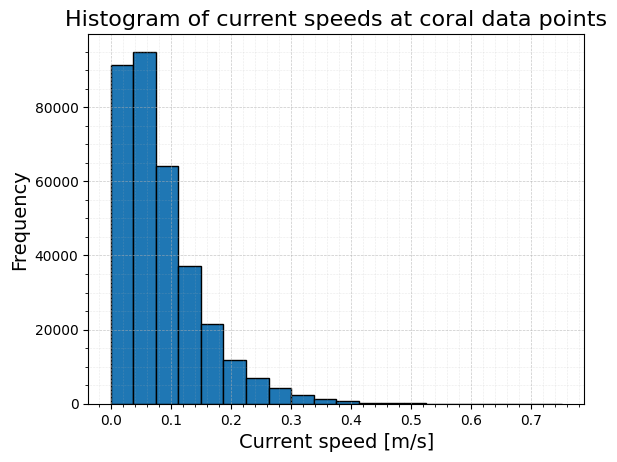

In [103]:
#Plot histogram of the current speeds midnor
plt.hist(current_speeds_midnor, bins=bin_edges, edgecolor='black')
plt.xlabel('Current speed [m/s]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title(f'Histogram of current speeds at coral data points', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Main grid
plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)  # Finer minor grid

plt.savefig(f'/cluster/home/maikents/current_speed_histogram_coral_points_midnor.png')
 
plt.show()